### Step1: Load POWER dataset

In [ ]:
import pandas as pd
import numpy as np

# Path to power txt file
file_path = './data/household_power_consumption.txt'
# Load with ; separator, handle '?' as NaN
data = pd.read_csv(file_path, sep=';', na_values='?')

# Combine Date and Time to datetime
data['datetime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], format='%d/%m/%Y %H:%M:%S')
# Numerical timestamp: seconds since the earliest date
min_dt = data['datetime'].min()
data['timestamp'] = (data['datetime'] - min_dt).dt.total_seconds()

# Relevant columns (drop Date/Time/datetime, keep numerics)
cols = ['timestamp', 'Global_active_power', 'Global_reactive_power', 'Voltage', 
        'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
data = data[cols].dropna()  # ~1.25% missing, drop for simplicity
full_data_size = len(data)
# Define dimensions (7D) and their min/max
dimensions = ['timestamp', 'Global_reactive_power', 'Voltage', 'Global_intensity', 
              'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
agg_col = 'Global_active_power'

print(f"Dataset loaded: {full_data_size} rows")
print(f"First 5 data: {data.head()}")

Dataset loaded: 2049280 rows
First 5 data:    timestamp  Global_active_power  Global_reactive_power  Voltage  \
0        0.0                4.216                  0.418   234.84   
1       60.0                5.360                  0.436   233.63   
2      120.0                5.374                  0.498   233.29   
3      180.0                5.388                  0.502   233.74   
4      240.0                3.666                  0.528   235.68   

   Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
0              18.4             0.0             1.0            17.0  
1              23.0             0.0             1.0            16.0  
2              23.0             0.0             2.0            17.0  
3              23.0             0.0             1.0            17.0  
4              15.8             0.0             1.0            17.0  


### Step2: Create a Small Offline Sample

In [42]:
sample_size = 2000
sample = data.sample(n=sample_size, random_state=42).copy()
print(f"Sample created: {sample.shape[0]} rows")
print(sample.head())

Sample created: 2000 rows
          timestamp  Global_active_power  Global_reactive_power  Voltage  \
1030580  61834800.0                1.502                  0.074   240.17   
1815       108900.0                0.374                  0.264   245.50   
1295977  77758620.0                0.620                  0.300   239.85   
206669   12400140.0                0.280                  0.200   235.72   
1048893  62933580.0                1.372                  0.054   243.95   

         Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
1030580               6.4             0.0             0.0            18.0  
1815                  1.8             0.0             2.0             0.0  
1295977               3.0             0.0             1.0             1.0  
206669                1.4             0.0             0.0             0.0  
1048893               5.6             0.0             0.0            18.0  


### Step 3: Generate Query Log, training data, testing data, optimize testing data.

Chapter 6.1: "In order to avoid most of the multi-dimensional query results to be zero, we limit the range to generate the boundaries in each dimension. The left boundary of the range in each dimension is randomly chosen from the first quarter of the entire value range of the corresponding attribute. Similarly, each right boundary is randomly chosen from the last quarter of the corresponding attribute range."

In [43]:
from query_generate import generate_random_query

# generate a random query to test and see min, max value.
q = generate_random_query(data, dimensions, test = True)
print(q)

dim: timestamp, min value: 0.0, max value: 124515480.0
dim: Global_reactive_power, min value: 0.0, max value: 1.39
dim: Voltage, min value: 223.2, max value: 254.15
dim: Global_intensity, min value: 0.2, max value: 48.4
dim: Sub_metering_1, min value: 0.0, max value: 88.0
dim: Sub_metering_2, min value: 0.0, max value: 80.0
dim: Sub_metering_3, min value: 0.0, max value: 31.0
{'timestamp': (24721110.443648413, 115549612.42759107), 'Global_reactive_power': (0.18842465264504107, 1.1538571162190774), 'Voltage': (230.55307679808595, 248.0023861064478), 'Global_intensity': (8.848833045283847, 37.68201000312058), 'Sub_metering_1': (6.49279697190779, 67.67600693187005), 'Sub_metering_2': (9.479897420360942, 61.14625417036388), 'Sub_metering_3': (2.7862079943996645, 24.693577976794494)}


Build query log (around 6 and a half mins), the main task is SUM.

In [44]:
from query_generate import generate_power_query_log

task = "SUM"
# number of queries
num_queries = 2000

avg_exact, query_log = generate_power_query_log(agg_col, num_queries, data, sample, dimensions, full_data_size, avg_exact=0)

query_log = generate_power_query_log(agg_col, num_queries, data, sample, dimensions, full_data_size, avg_exact=avg_exact)

Generating power query log...
Average exact sum: avg_exact=10353.889154999999

Generated 2000 queries
Generating power query log...
Generated 2000 queries


In [45]:
# Check any query in query log.
query_log[100]

{'query': {'timestamp': (28392507.578278627, 111339658.09464934),
  'Global_reactive_power': (0.15813855284636033, 1.3814659572208199),
  'Voltage': (226.88768299412953, 248.32986457867332),
  'Global_intensity': (9.664022779714616, 45.512991615874455),
  'Sub_metering_1': (10.43799912273651, 86.19609793637437),
  'Sub_metering_2': (7.445628686571362, 63.18734789893813),
  'Sub_metering_3': (4.05872225254117, 26.149919416191096)},
 'exact': 7233.8060000000005,
 'estimate': 4834.251520000001,
 'error': 2399.55448}

Build training data with diversification.

In [46]:
from diversification import diversify_query_log

training_data_query_log = diversify_query_log(query_log, dimensions, k=800)

Diversified query log: selected 800 / 2000 entries


In [47]:
# CHeck any query in diversify query log.
training_data_query_log[100]

{'query': {'timestamp': (1655855.0012850312, 123027876.7600747),
  'Global_reactive_power': (0.11183067619224177, 1.0809888752658876),
  'Voltage': (230.84561160553181, 247.66107096601513),
  'Global_intensity': (5.5805449752502625, 47.553478657111214),
  'Sub_metering_1': (3.023144598937391, 87.03386879209253),
  'Sub_metering_2': (12.136737228444197, 79.99558513707984),
  'Sub_metering_3': (5.559714534189212, 23.40567064420494)},
 'exact': 12682.05,
 'estimate': 10896.021760000001,
 'error': 1786.0282399999978}

Graph of before diversification and after.

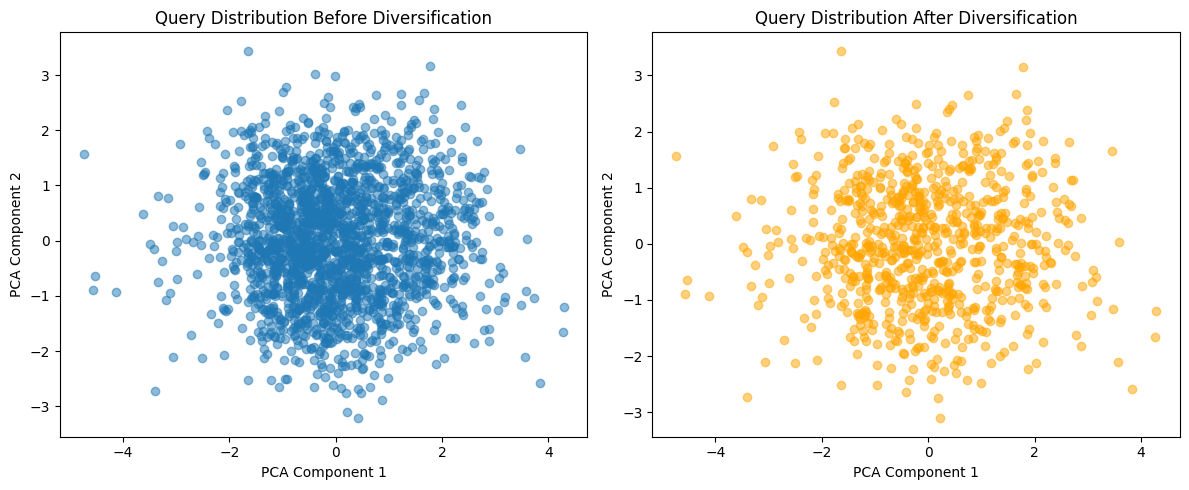

In [49]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from visualization import extract_features

scaler = StandardScaler()

# Extract features for original and diversified
original_features = extract_features(query_log, dimensions)
diversified_features = extract_features(training_data_query_log, dimensions)

# Standardize
original_scaled = scaler.fit_transform(original_features)
diversified_scaled = scaler.transform(diversified_features)  # Use same scaler for consistency

# Apply PCA to reduce to 2D
pca = PCA(n_components=2)
original_pca = pca.fit_transform(original_scaled)
diversified_pca = pca.transform(diversified_scaled)  # Use same PCA

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Before diversification
axes[0].scatter(original_pca[:, 0], original_pca[:, 1], alpha=0.5)
axes[0].set_title('Query Distribution Before Diversification')
axes[0].set_xlabel('PCA Component 1')
axes[0].set_ylabel('PCA Component 2')

# After diversification
axes[1].scatter(diversified_pca[:, 0], diversified_pca[:, 1], alpha=0.5, color='orange')
axes[1].set_title('Query Distribution After Diversification')
axes[1].set_xlabel('PCA Component 1')
axes[1].set_ylabel('PCA Component 2')

plt.tight_layout()
plt.show()

Build testing data.

In [50]:
testing_data_query_log = generate_power_query_log(agg_col, 100, data, sample, dimensions, full_data_size, avg_exact=avg_exact)

Generating power query log...
Generated 100 queries


Check training, testing data size.

In [51]:
print("Training data: ", len(training_data_query_log), "\nTesting data: ",  len(testing_data_query_log))

Training data:  800 
Testing data:  100


### Step 4: Train the Error Prediction Model

Load model if needed.

In [ ]:
# import joblib

# model_data = joblib.load("regression_pipeline.pkl")
# model = model_data["model"]

Train model.

In [52]:
from sklearn.ensemble import RandomForestRegressor

# Input query and output x, y
def data_split(query_log):
    # Prepare features (flatten: lower/upper per dim) and targets (errors)
    X = []
    y = []
    for entry in query_log:

        vec = []
        for dim in dimensions:
            lower, upper = entry['query'][dim]
            vec.extend([lower, upper])
        X.append(vec)
        y.append(entry['error'])

    X = np.array(X)
    y = np.array(y)

    # Normalize
    X_scaled = scaler.fit_transform(X)

    return X_scaled, y

X_train, y_train = data_split(training_data_query_log)
X_test, y_test = data_split(testing_data_query_log)

# Use max_depth = 3 as paper mentioned.
model = RandomForestRegressor(
    # n_estimators=200,
    max_depth=3,
    min_samples_leaf=5,       # 防止樹太碎
    max_features="sqrt",      # 每棵樹隨機挑特徵
    random_state=42
)

model.fit(X_train, y_train)

print(f"Model trained.")

# Evaluate model using MSE.
train_mse = np.mean((model.predict(X_train) - y_train) ** 2)
test_mse  = np.mean((model.predict(X_test)  - y_test)  ** 2)
print(f"Train MSE: {train_mse}")
print(f"Test  MSE: {test_mse}")


Model trained.
Train MSE: 11243188.835471159
Test  MSE: 12014853.604609376


### Step 5: Estimate a New Query

In [53]:
new_query = generate_random_query(data, dimensions, test = True)
print(new_query)

dim: timestamp, min value: 0.0, max value: 124515480.0
dim: Global_reactive_power, min value: 0.0, max value: 1.39
dim: Voltage, min value: 223.2, max value: 254.15
dim: Global_intensity, min value: 0.2, max value: 48.4
dim: Sub_metering_1, min value: 0.0, max value: 88.0
dim: Sub_metering_2, min value: 0.0, max value: 80.0
dim: Sub_metering_3, min value: 0.0, max value: 31.0
{'timestamp': (22918994.421845417, 101838416.13394147), 'Global_reactive_power': (0.24519796216056033, 1.3215639977090288), 'Voltage': (223.54364681843083, 251.49150953062036), 'Global_intensity': (8.30948850635946, 47.856815377692), 'Sub_metering_1': (15.437792715133252, 74.3307732725613), 'Sub_metering_2': (0.7389030372669625, 76.34479192977099), 'Sub_metering_3': (2.380232192837087, 23.6994676495594)}


In [54]:
from query_calculate import sample_sum, exact_sum

# Flatten and scale
new_vec = []
for dim in dimensions:
    lower, upper = new_query[dim]
    new_vec.extend([lower, upper])
new_vec = np.array([new_vec])
new_scaled = scaler.transform(new_vec)

# Predict error
predicted_error = model.predict(new_scaled)[0]

# Find error-similar historical query (closest error)
min_diff = float('inf')
opt_entry = None
for entry in training_data_query_log:
    error_diff = abs(entry['error'] - predicted_error)
    if error_diff < min_diff:
        min_diff = error_diff
        opt_entry = entry

# Compute final estimate
sample_new = sample_sum(agg_col, new_query, sample, full_data_size)
sample_opt = opt_entry['estimate']
final_estimate = opt_entry['exact'] + (sample_new - sample_opt)

print(f"LAQP estimate: {final_estimate:.2f}")
# Compute exact for the same query (for debugging/small queries)
exact = exact_sum(agg_col, new_query, data)
print(f"Exact sum: {exact:.2f}")
print(f"Relative error: {abs(final_estimate - exact) / exact:.4f}")

LAQP estimate: 18804.97
Exact sum: 19453.26
Relative error: 0.0333


### Step 6: Evaluate and Extend

Optimization


In [55]:
from optimization import optimize_alpha, range_distance

best_alpha = optimize_alpha(training_data_query_log, testing_data_query_log, dimensions, scaler, model, sample, full_data_size)

Optimized alpha: 0.618 (MSE on val: 0.5586)


In [56]:
from estimation import optimized_laqp_estimate
from estimation import laqp_estimate

estimate, opt_idx, opt_entry = laqp_estimate(training_data_query_log, new_query, sample, dimensions, model, scaler, full_data_size, task)

# Optimized (hybrid with best_alpha)
opt_est, opt_entry = optimized_laqp_estimate(training_data_query_log, new_query, sample, dimensions, model, scaler, full_data_size, task, best_alpha)

# Compare
exact = exact_sum(agg_col, new_query, data)  # Or use exact_sum if needed
print(f"\nExact: {exact}")
print(f"Basic rel error: {abs(estimate - exact) / exact:.4f}")
print(f"Optimized rel error: {abs(opt_est - exact) / exact:.4f}")

Selected optimal query index: 776 (out of  800)
Basic LAQP estimate: 18804.97
Predicted error for new query: 42.32
Chosen historical query error: 152.43 (diff: 110.11)

Optimized LAQP estimate: 22303.77
Predicted error for new query: 42.32
Chosen historical query error: 3651.23

Exact: 19453.260000000002
Basic rel error: 0.0333
Optimized rel error: 0.1465


Generate evaluation query log (100).

In [57]:
evaluation_query_log = generate_power_query_log(agg_col, 100, data, sample, dimensions, full_data_size, avg_exact=avg_exact)

Generating power query log...
Generated 100 queries


In [58]:
# Evaluation on evaluation_query_log 
laqp_rel_errors = []
sampling_rel_errors = []
laqp_squared_errors = []
sampling_squared_errors = []
laqp_abs_errors = []
sampling_abs_errors = []

min_exact_threshold = 100 
filtered_count = 0

for tq in evaluation_query_log:
    query = tq['query']
    exact = tq['exact']
    
    if exact < min_exact_threshold:
        continue
    filtered_count += 1
    
    # Pure Sampling Estimate
    sample_est = sample_sum(agg_col, query, sample, full_data_size)
    sampling_abs = abs(sample_est - exact)
    sampling_rel = sampling_abs / exact if exact > 0 else 0
    sampling_sq = (sample_est - exact)**2
    
    sampling_abs_errors.append(sampling_abs)
    sampling_rel_errors.append(sampling_rel)
    sampling_squared_errors.append(sampling_sq)
    
    # LAQP Estimate (with Hybrid)
    vec = [query[dim][i] for dim in dimensions for i in range(2)]
    vec = np.array([vec])
    scaled = scaler.transform(vec)
    pred_error = model.predict(scaled)[0]
    best_entry = min(training_data_query_log, key=lambda e:
        best_alpha * abs(e['error'] - pred_error) + 
        (1 - best_alpha) * range_distance(dimensions, query, e['query']))
    sample_new = sample_sum(agg_col, query, sample, full_data_size)
    sample_opt = best_entry['estimate']
    laqp_est = best_entry['exact'] + (sample_new - sample_opt)
    
    laqp_abs = abs(laqp_est - exact)
    laqp_rel = laqp_abs / exact if exact > 0 else 0
    laqp_sq = (laqp_est - exact)**2
    
    laqp_abs_errors.append(laqp_abs)
    laqp_rel_errors.append(laqp_rel)
    laqp_squared_errors.append(laqp_sq)

# Results
print(f"Evaluated on {filtered_count} / {len(evaluation_query_log)} queries "
      f"(excluded {len(evaluation_query_log)-filtered_count} tiny ones)")

if len(laqp_rel_errors) > 0:
    laqp_are = np.mean(laqp_rel_errors)
    sampling_are = np.mean(sampling_rel_errors)
    laqp_mse = np.mean(laqp_squared_errors)
    sampling_mse = np.mean(sampling_squared_errors)
    laqp_mae = np.mean(laqp_abs_errors)
    sampling_mae = np.mean(sampling_abs_errors)
    
    print(f"\nLAQP    Average Relative Error (ARE): {laqp_are:.4f}")
    print(f"LAQP    Median Relative Error:       {np.median(laqp_rel_errors):.4f}")
    print(f"LAQP    Mean Squared Error (MSE):    {laqp_mse:.2f}")
    print(f"LAQP    Mean Absolute Error (MAE):   {laqp_mae:.2f}")
    
    print(f"\nSampling ARE:                       {sampling_are:.4f}")
    print(f"Sampling Median Relative Error:     {np.median(sampling_rel_errors):.4f}")
    print(f"Sampling MSE:                       {sampling_mse:.2f}")
    print(f"Sampling MAE:                       {sampling_mae:.2f}")
    
    improvement = sampling_are / laqp_are if laqp_are > 0 else 0
    print(f"\nImprovement (Sampling ARE / LAQP ARE): {improvement:.2f}x")
else:
    print("No queries passed the threshold — lower min_exact_threshold")

Evaluated on 100 / 100 queries (excluded 0 tiny ones)

LAQP    Average Relative Error (ARE): 0.4947
LAQP    Median Relative Error:       0.3195
LAQP    Mean Squared Error (MSE):    30800244.61
LAQP    Mean Absolute Error (MAE):   4027.68

Sampling ARE:                       0.7278
Sampling Median Relative Error:     1.0000
Sampling MSE:                       43216231.94
Sampling MAE:                       5849.13

Improvement (Sampling ARE / LAQP ARE): 1.47x


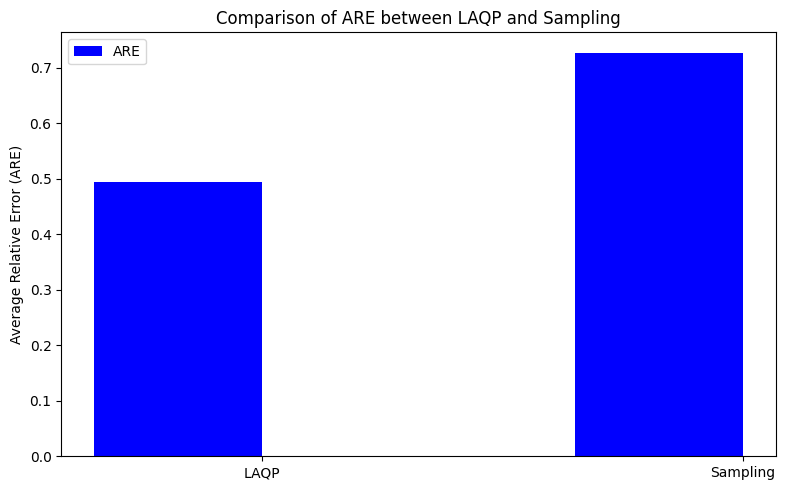

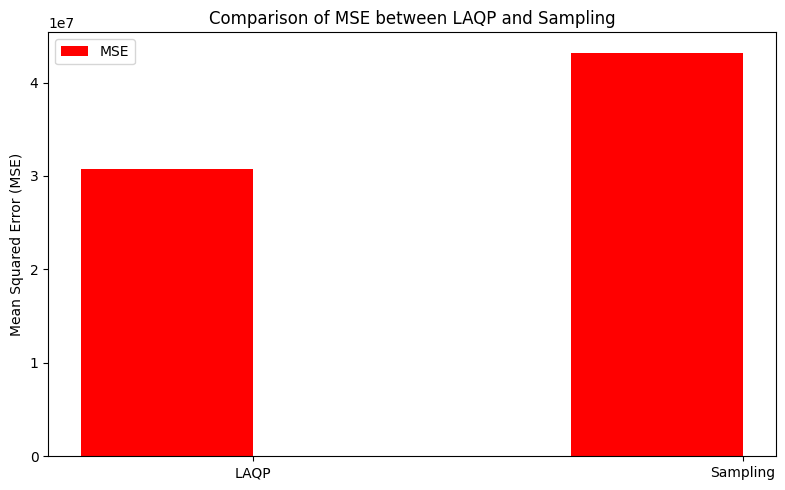

In [59]:
import matplotlib.pyplot as plt
import numpy as np

# Use computed metrics from above
methods = ['LAQP', 'Sampling']
are_values = [laqp_are, sampling_are]
mse_values = [laqp_mse, sampling_mse]

# Bar chart for ARE
fig, ax1 = plt.subplots(figsize=(8, 5))
x = np.arange(len(methods))
width = 0.35
ax1.bar(x - width/2, are_values, width, label='ARE', color='blue')
ax1.set_ylabel('Average Relative Error (ARE)')
ax1.set_title('Comparison of ARE between LAQP and Sampling')
ax1.set_xticks(x)
ax1.set_xticklabels(methods)
ax1.legend(loc='upper left')
plt.tight_layout()
plt.show()

# Bar chart for MSE
fig, ax2 = plt.subplots(figsize=(8, 5))
ax2.bar(x - width/2, mse_values, width, label='MSE', color='red')
ax2.set_ylabel('Mean Squared Error (MSE)')
ax2.set_title('Comparison of MSE between LAQP and Sampling')
ax2.set_xticks(x)
ax2.set_xticklabels(methods)
ax2.legend(loc='upper left')
plt.tight_layout()
plt.show()

Save if needed.

In [61]:
import joblib

joblib.dump({
    "model": model,
}, "./weights/12_27_power.pkl")

['./weights/12_27_power.pkl']